In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error as MSE, make_scorer

from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU, PReLU
from keras.optimizers import SGD, Adam

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import pickle
import datetime

In [41]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_test = pd.concat([train, test], ignore_index=True, sort=False)

# Preprocessing

## car name, car brand

In [42]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

In [43]:
train_test['car_brand'] = train_test['car name'].apply(lambda x: x.strip().split(' ')[0])

## horse power

In [44]:
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

In [45]:
# car name毎のhorse powerの平均値を計算(nanは計算外)
name_hp_mean = train_test.groupby('car name').horsepower.mean()
df_hp_isnull = train_test[train_test['horsepower'].isnull()]

# nan位置のtrainデータのhorse powerを置換する
for i in df_hp_isnull.index:
    train_test.loc[i, 'horsepower'] = name_hp_mean[df_hp_isnull.loc[i, 'car name']]
    
del df_hp_isnull, name_hp_mean

# LabelEncoding

In [46]:
cat_cols = ['car name', 'car_brand']
for cols in cat_cols:
    train_test[cols] = LabelEncoder().fit_transform(train_test[cols])

del cat_cols

# Onep-Hot-Encoding

cat_cols = ['cylinders', 'model year', 'origin', 'car name', 'car_brand']
train_test = pd.get_dummies(
    train_test,
    columns=cat_cols, 
    sparse=False
)

display(train_test)

# Create Model 

In [47]:
test_treated = train_test[train_test['mpg'].isnull()].copy()
train_treated = train_test.dropna(subset=['mpg'], axis=0).copy()

train_x = train_treated.drop(['id', 'mpg'], axis=1)
train_y = train_treated['mpg']

In [62]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

In [49]:
print("tr_x:", tr_x.shape)
print("tr_y:", tr_y.shape)

print("va_x:", va_x.shape)
print("va_y:", va_y.shape)

tr_x: (375, 9)
tr_y: (375,)
va_x: (125, 9)
va_y: (125,)


In [1]:
class MLP:

    def __init__(self, params):
        self.params = params
        self.scaler = None
        self.model = None

    def fit(self, tr_x, tr_y, va_x, va_y):

        # パラメータ
        input_dropout = self.params['input_dropout']
        hidden_layers = int(self.params['hidden_layers'])
        hidden_units = int(self.params['hidden_units'])
        hidden_activation = self.params['hidden_activation']
        hidden_dropout = self.params['hidden_dropout']
        batch_norm = self.params['batch_norm']
        optimizer_type = self.params['optimizer']['type']
        optimizer_lr = self.params['optimizer']['lr']
        batch_size = int(self.params['batch_size'])

        # 標準化
        self.scaler = StandardScaler()
        tr_x = self.scaler.fit_transform(tr_x)
        va_x = self.scaler.transform(va_x)

        # Layer Setting
        self.model = Sequential()
        self.model.add(Dropout(input_dropout, input_shape=(tr_x.shape[1],)))# 入力層
        for i in range(hidden_layers):# 中間層
            self.model.add(Dense(hidden_units))
            if batch_norm == 'before_act':
                self.model.add(BatchNormalization())
            if hidden_activation == 'prelu':
                self.model.add(PReLU())
            elif hidden_activation == 'relu':
                self.model.add(ReLU())
            else:
                raise NotImplementedError
            self.model.add(Dropout(hidden_dropout))
        self.model.add(Dense(1))# 出力層

        # オプティマイザ
        if optimizer_type == 'sgd':
            optimizer = SGD(lr=optimizer_lr, decay=1e-6, momentum=0.9, nesterov=True)
        elif optimizer_type == 'adam':
            optimizer = Adam(lr=optimizer_lr, beta_1=0.9, beta_2=0.999, decay=0.)
        else:
            raise NotImplementedError

        # 目的関数、評価指標などの設定
        self.model.compile(loss='mean_squared_error',
                           optimizer=optimizer, metrics=['mse'])

        # エポック数、アーリーストッピング
        # あまりepochを大きくすると、小さい学習率のときに終わらないことがあるので注意
        nb_epoch = 200
        patience = 20
        early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

        # 学習の実行
        history = self.model.fit(tr_x, tr_y,
                                 epochs=nb_epoch,
                                 batch_size=batch_size, verbose=0,
                                 validation_data=(va_x, va_y),
                                 callbacks=[early_stopping])

    def predict(self, x):
        # 予測
        x = self.scaler.transform(x)
        y_pred = self.model.predict(x)
        y_pred = y_pred.flatten()
        return y_pred


In [95]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(params):    
    model = MLP(params)
    model.fit(tr_x, tr_y, va_x, va_y)
    va_pred = model.predict(va_x)
    score = RMSE(va_y, va_pred)
    print(f'params:{params} \n RMSE:{score:.4f}')
    
    history.append((params, score))
    
    return {
        'loss':score,
        'status':STATUS_OK,
        'params':params
    }

In [52]:
base_param = {
    'input_dropout': 0.0,
    'hidden_layers': 3,
    'hidden_units': 96,
    'hidden_activation': 'relu',
    'hidden_dropout': 0.2,
    'batch_norm': 'before_act',
    'optimizer': {'type': 'adam', 'lr': 0.001},
    'batch_size': 64,
}

In [100]:
param_space ={
    'batch_norm': hp.choice(
        label='batch_norm', options=['no']#'before_act', 
    ),
    'batch_size': hp.quniform(label='batch_size', low=10, high=100, q=16),
    'hidden_activation': hp.choice(
        label='hidden_activation', options=['prelu', 'relu']
    ),
    'hidden_dropout': hp.quniform(
        label='hidden_dropout', low=0.05, high=0.4, q=0.05
    ),
    'hidden_layers': 3,#hp.quniform(label='hidden_layers', low=3, high=4, q=1),
    'hidden_units': hp.quniform(
        label='hidden_units', low=200, high=320, q=16
    ),
    'input_dropout': hp.quniform(
        label='input_dropout', low=0.1, high=0.4, q=0.025
    ),
    'optimizer': hp.choice(
        label='optimizer',
        options=[{'type': 'adam',
                  'lr': hp.loguniform(
                      label='adam_lr', low=np.log(0.0001), high=np.log(0.01)
                  )},
                 #{'type': 'sgd', 
                 #'lr': hp.loguniform('sgd_lr', np.log(0.00001), np.log(0.01))}
                ])
}

In [101]:
max_evals = 50
nn_trials = Trials()
history = []
best = fmin(objective, param_space, algo=tpe.suggest, trials=nn_trials, max_evals=max_evals)

params:{'batch_norm': 'no', 'batch_size': 16.0, 'hidden_activation': 'relu', 'hidden_dropout': 0.4, 'hidden_layers': 3, 'hidden_units': 320.0, 'input_dropout': 0.2, 'optimizer': {'lr': 0.0025195859716921534, 'type': 'adam'}} 
 RMSE:3.5518
params:{'batch_norm': 'no', 'batch_size': 48.0, 'hidden_activation': 'prelu', 'hidden_dropout': 0.30000000000000004, 'hidden_layers': 3, 'hidden_units': 240.0, 'input_dropout': 0.4, 'optimizer': {'lr': 0.0020828765577333283, 'type': 'adam'}} 
 RMSE:4.0601
params:{'batch_norm': 'no', 'batch_size': 80.0, 'hidden_activation': 'relu', 'hidden_dropout': 0.30000000000000004, 'hidden_layers': 3, 'hidden_units': 240.0, 'input_dropout': 0.30000000000000004, 'optimizer': {'lr': 0.001707191196465668, 'type': 'adam'}} 
 RMSE:3.6832
params:{'batch_norm': 'no', 'batch_size': 32.0, 'hidden_activation': 'prelu', 'hidden_dropout': 0.25, 'hidden_layers': 3, 'hidden_units': 208.0, 'input_dropout': 0.2, 'optimizer': {'lr': 0.003742674226346342, 'type': 'adam'}} 
 RMSE:3.

,loss,batch_norm,batch_size,hidden_activation,hidden_dropout,hidden_layers,hidden_units,input_dropout,optimizer
0,3.067665,no,32.0,prelu,0.15,3,272.0,0.100,"{'lr': 0.002485112914796712, 'type': 'adam'}"
1,3.193116,no,64.0,prelu,0.05,3,272.0,0.125,"{'lr': 0.009915284039971314, 'type': 'adam'}"
2,3.205939,no,80.0,prelu,0.10,3,208.0,0.100,"{'lr': 0.0007613060407017325, 'type': 'adam'}"
3,3.211124,no,64.0,relu,0.10,3,272.0,0.125,"{'lr': 0.0056882077768612765, 'type': 'adam'}"
4,3.237130,no,48.0,prelu,0.20,3,240.0,0.125,"{'lr': 0.004679248047046594, 'type': 'adam'}"
5,3.267925,no,64.0,prelu,0.10,3,304.0,0.100,"{'lr': 0.0012922851971464478, 'type': 'adam'}"
6,3.290958,no,64.0,relu,0.15,3,256.0,0.100,"{'lr': 0.0026704819856219943, 'type': 'adam'}"
7,3.303470,no,64.0,prelu,0.15,3,288.0,0.150,"{'lr': 0.005327193169706696, 'type': 'adam'}"
8,3.329514,no,96.0,relu,0.10,3,272.0,0.125,"{'lr': 0.0060302032939890775, 'type': 'adam'}"
9,3.335307,no,48.0,prelu,0.10,3,272.0,0.125,"{'lr': 0.0014281239813680863, 'type': 'adam'}"


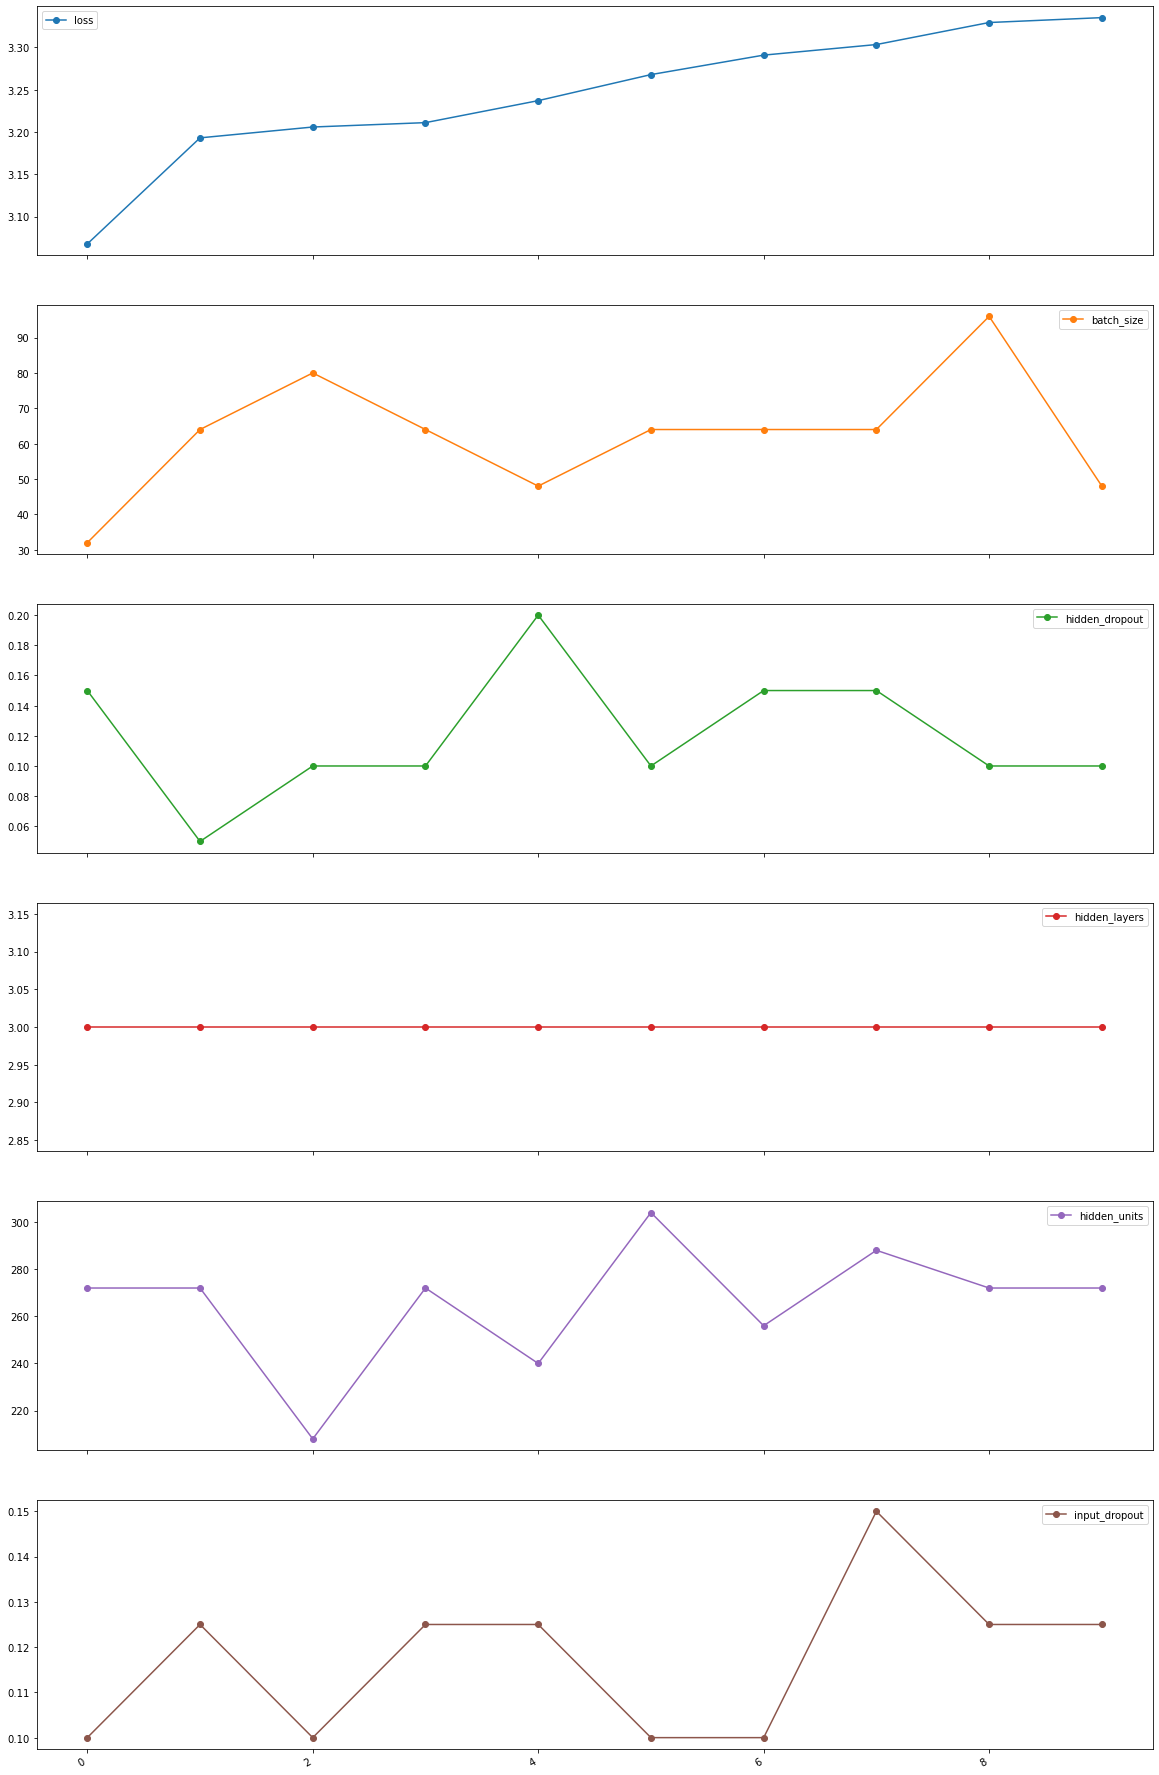

In [102]:
# trialsからスコアとパラメータを取り出し
result = [(i['loss'], i['params']) for i in sorted(nn_trials.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses = [i[0] for i in result]
opt_params = [i[1] for i in result]
# スコアとパラメータをDataFrame化
opt_params_df = pd.concat([pd.Series(losses, name='loss'), pd.DataFrame(opt_params)], axis=1)
display(opt_params_df[:10])

opt_params_df.iloc[:10, :].plot.line(figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True)
plt.show()

In [103]:
best_loss = losses[0]
best_params = opt_params[0]

print("best_loss: ")
pprint.pprint(best_loss)
print("\nbest_params: ")
pprint.pprint(best_params)

best_loss: 
3.067665423129504

best_params: 
{'batch_norm': 'no',
 'batch_size': 32.0,
 'hidden_activation': 'prelu',
 'hidden_dropout': 0.15000000000000002,
 'hidden_layers': 3,
 'hidden_units': 272.0,
 'input_dropout': 0.1,
 'optimizer': {'lr': 0.002485112914796712, 'type': 'adam'}}


# Create Submission

In [105]:
best_model = MLP(best_params)
best_model.fit(tr_x, tr_y, va_x, va_y)
score = RMSE(va_y, best_model.predict(va_x))
pprint.pprint(best_params)
print(f'RMSE:{score:.4f}')

pred = best_model.predict(test_treated.drop(['id', 'mpg'], axis=1))

{'batch_norm': 'no',
 'batch_size': 32.0,
 'hidden_activation': 'prelu',
 'hidden_dropout': 0.15000000000000002,
 'hidden_layers': 3,
 'hidden_units': 272.0,
 'input_dropout': 0.1,
 'optimizer': {'lr': 0.002485112914796712, 'type': 'adam'}}
RMSE:3.1731


In [106]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
submission = pd.DataFrame({'id':sample_sub.id})

submission = pd.concat(
    [submission, pd.Series(pred, name='pred')],
    axis=1
)

display(submission)

,id,pred
0,1,35.660259
1,2,28.712851
2,5,27.431248
3,6,30.351887
4,8,27.350935
...,...,...
495,992,27.820080
496,993,31.684044
497,996,17.529816
498,998,27.454332


# Save Files

In [108]:
# features
train_treated.to_pickle('../features/feature_train_' + dt + '_nn.pkl')
test_treated.to_pickle('../features/feature_test_' + dt + '_nn.pkl')

# submission
submission[['id', 'pred']].to_csv('../data/output/sub_' + dt + '_nn.csv', header=False, index=False)
# model
pickle.dump(best_model, open('../models/model_' + dt + '_nn.pickle', 'wb'))
# best parameter
pickle.dump(best_params, open('../logs/params_' + dt + '_nn.pickle', 'wb'))
# best train score
pickle.dump(score, open('../logs/train_score_' + dt + '_nn.pickle', 'wb'))